# Non-Adaptive Preconditioned Consistent Bayes

This is a notebook for implementing preconditioned rejection sampling for the consistent Bayesian approach. Samples are used to compute the push-forward of the prior. Rejection sampling is then applied to these samples to generate samples from the posterior. We apply Gaussian Kernel Density Estimation to these posterior samples to generate an approximation to the posterior pdf and use this to formulate a new proposal distribution that yields a better acceptance rate.

## Import neccesary libraries

In [1]:
import numpy as np
# from matplotlib import rc_file
# rc_file( './mpl_latexrc' )
# Using "%matplotlib notebook" for more interactive plots
%matplotlib notebook
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})
import sys
import scipy.stats as sstats
from scipy.stats import gaussian_kde as gkde


## Sample uniformly from $\Lambda=[-1,1]\subset\mathbb{R}$

In [2]:
num_samples = int(5E4)

# Uniform sampling
#lam = np.random.uniform(low=[-1.,-1.],high=[1.,0.],size=(num_samples,2))
a = -1.0
b = 1.0
lam = np.random.uniform(low=a,high=b,size=num_samples)

# Gaussian sampling
#lam = np.random.normal(loc=([0.0,-0.5]),scale=([0.5,0.5]),size=(num_samples,2))
   
lam = np.transpose(lam)
print(lam)

[-0.15700693 -0.15713023 -0.01766079 ...  0.95982176 -0.60833678
 -0.44699786]


## Compute the QoI Samples

In [3]:
def model(x,p):
    if isinstance(p,int) == False:
        sys.exit("Error, model expected integer for second argument.")
    else:
        y = x**p
        return y

In [4]:
# Define nonlinearity parameter to be used throughout code
param = 5

In [5]:
q = model(lam,param)

## Compute the push-forward of prior

In [6]:
pf_dens = gkde(q)

## Define the observed density

In [7]:
mu = 0.25
sigma = 0.1

obs_dens = sstats.norm(mu,sigma)

In [8]:
# Stat Bayes - hardcoded with uniform prior from -1 to 1
def statBayesPost(x):
    y = obs_dens.pdf(model(x,param))
    return y

In [9]:
import scipy.integrate as integrate
intConst=integrate.quad(statBayesPost,-1,1)

In [24]:
intConst

(0.8670861016200645, 5.186132031226353e-13)

In [11]:
# Generate samlpes from the Classical Bayesian posterior
#num_samples_prop = int(5E5)
#lam_prop = np.random.uniform(low=-1.,high=1.,size=num_samples_prop)
lam_classical = []
r = obs_dens.pdf(q)
M = np.max(r)
eta_r = r/M
for i in range(num_samples):
    xi = np.random.uniform(0,1)
    if eta_r[i] > xi:
        lam_classical.append(lam[i])
        
lam_classical = np.array(lam_classical)

print(lam_classical.shape)
print(np.sum(lam_classical)/lam_classical.size)

(5557,)
0.5752825485666623


In [12]:
q_classical = model(lam_classical,param)

In [13]:
pf_classical = gkde(q_classical)

<IPython.core.display.Javascript object>


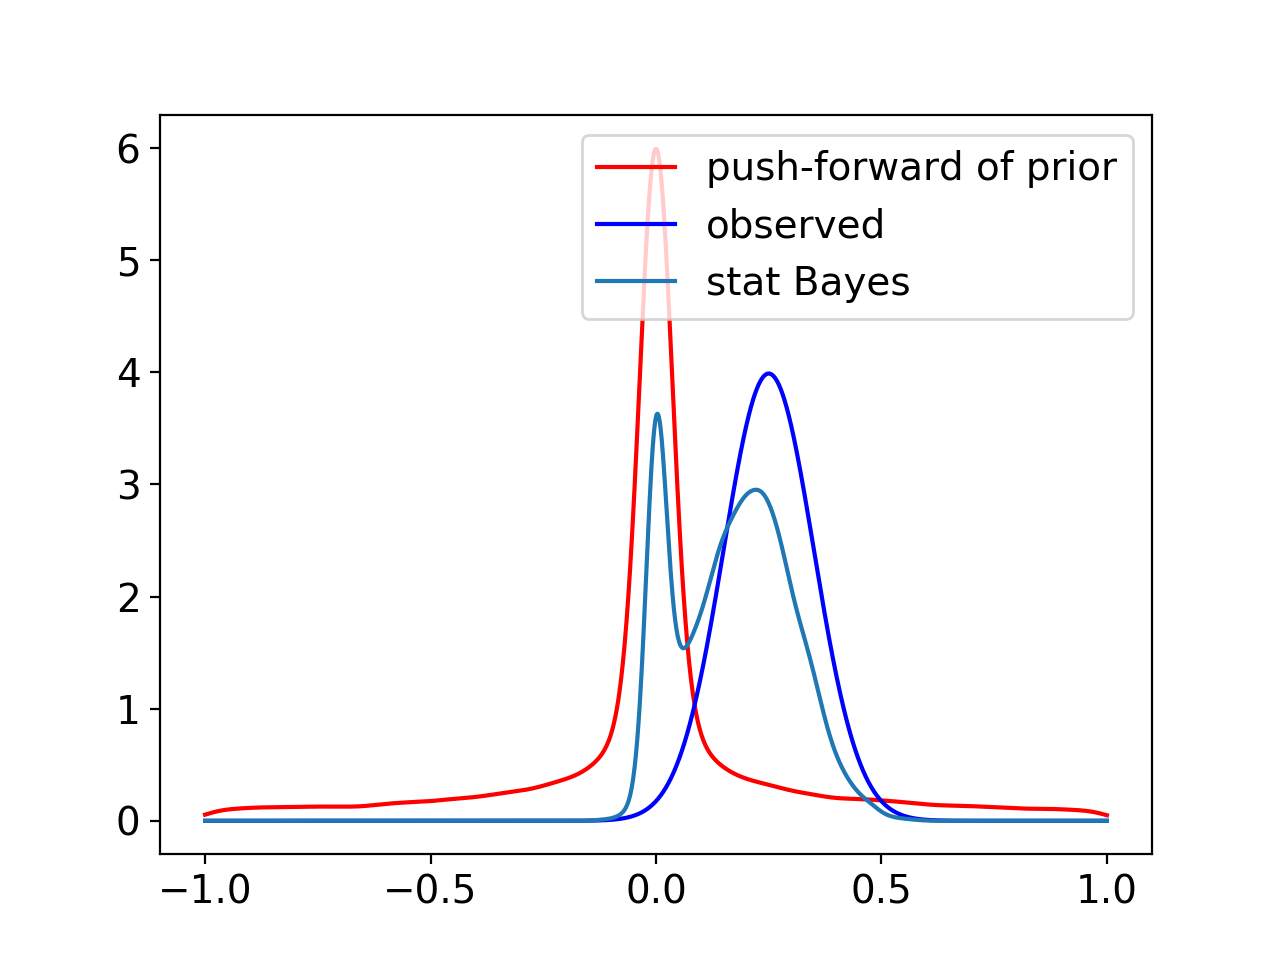

In [14]:
x = np.linspace(-1.0,1.0,2000)

plt.figure()

plt.plot(x,pf_dens.evaluate(x),'r',label='push-forward of prior')
plt.plot(x,obs_dens.pdf(x),'b',label='observed')
plt.plot(x,pf_classical(x),label='stat Bayes')
plt.legend()
plt.show()

## Perform accept/reject on the prior samples

In [15]:
lam_accept = []
r = obs_dens.pdf(q)/pf_dens.evaluate(q)
M = np.max(r)
eta_r = r/M
for i in range(num_samples):
    xi = np.random.uniform(0,1)
    if eta_r[i] > xi:
        lam_accept.append(lam[i])

# Make accepted samples into array object
lam_accept = np.array(lam_accept)

In [16]:
pf_consistent = gkde(model(lam_accept,param))

<IPython.core.display.Javascript object>


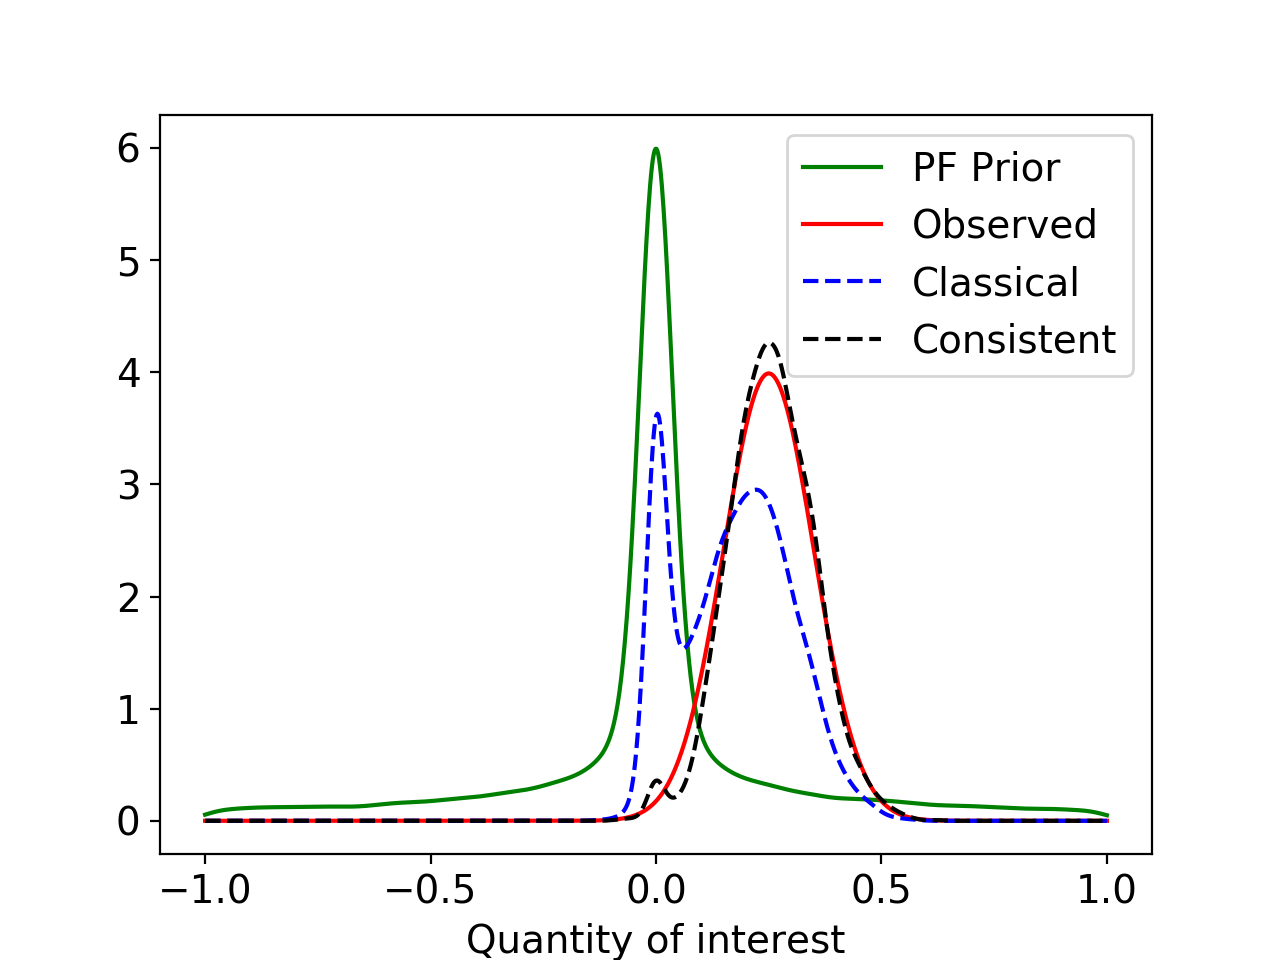

In [17]:
x = np.linspace(-1.0,1.0,1000)

plt.figure()

plt.plot(x,pf_dens.evaluate(x),'g',label='PF Prior')
plt.plot(x,obs_dens.pdf(x),'r',label='Observed')
plt.plot(x,pf_classical(x),'b--',label='Classical')
plt.plot(x,pf_consistent(x),'k--',label='Consistent')
plt.xlabel('Quantity of interest')
plt.legend()
# plt.savefig('figures/1D_pf.pdf', bbox_inches='tight')
plt.show()

In [18]:
def classicalBayesPosterior(x):
    y = obs_dens.pdf(model(x,param))
    return y

0.8670861016200645
0.9990000000000026
0.9460499521862915


<IPython.core.display.Javascript object>


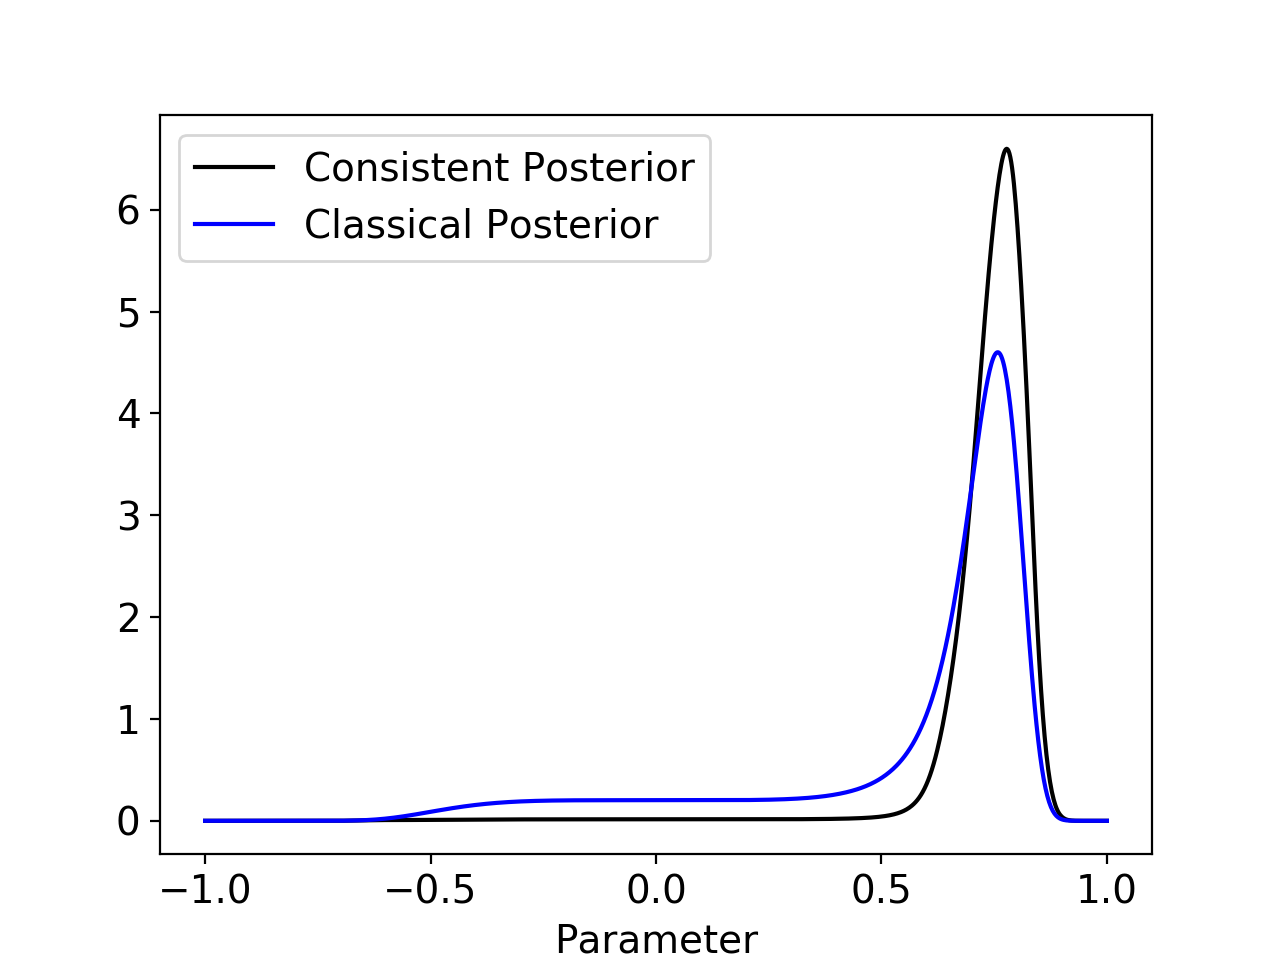

In [19]:
num_pts = 1000
x = np.linspace(a,b,num_pts)
cBayesPost=0.5*obs_dens.pdf(model(x,param))/pf_dens.evaluate(model(x,param))
normConst=integrate.quad(classicalBayesPosterior,-1,1)[0]
print(normConst)
classicalPost=obs_dens.pdf(model(x,param))/normConst
print(np.sum(classicalPost)*((b-a)/num_pts))
print(np.sum(cBayesPost)*((b-a)/num_pts))

plt.figure()
plt.plot(x,cBayesPost,'k',label='Consistent Posterior')
plt.plot(x,classicalPost,'b',label='Classical Posterior')
plt.xlabel('Parameter')
plt.legend()

# plt.savefig('figures/1D_post.pdf', bbox_inches='tight')
plt.show()

In [20]:
print(lam_accept.shape)

count = lam_accept.shape[0]
print("Acceptance rate is ",float(count)/float(num_samples))

(3523,)
Acceptance rate is  0.07046


(3523,)


<IPython.core.display.Javascript object>


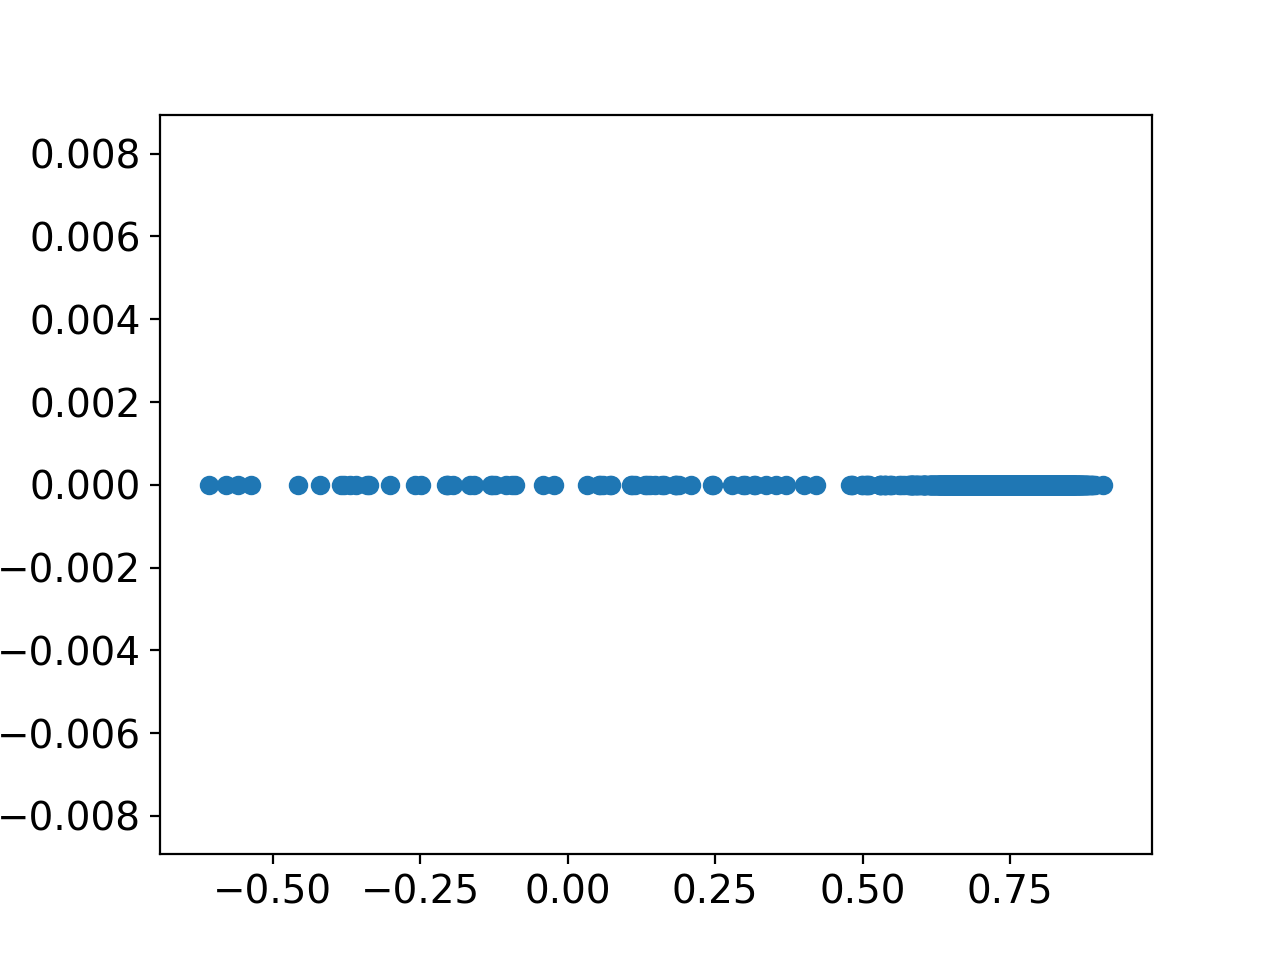

In [21]:
print(lam_accept.shape)
plt.figure()
plt.scatter(lam_accept,np.zeros_like(lam_accept))
plt.show()

#plt.figure()
#plt.scatter(lam[0,:],lam[1,:])
#plt.scatter(lam_accept[0,1:],lam_accept[1,1:])
#plt.show()

In [22]:
post_approx = gkde(lam_accept,bw_method=0.1)
post_approx_classical = gkde(lam_classical,bw_method=0.1)

<IPython.core.display.Javascript object>


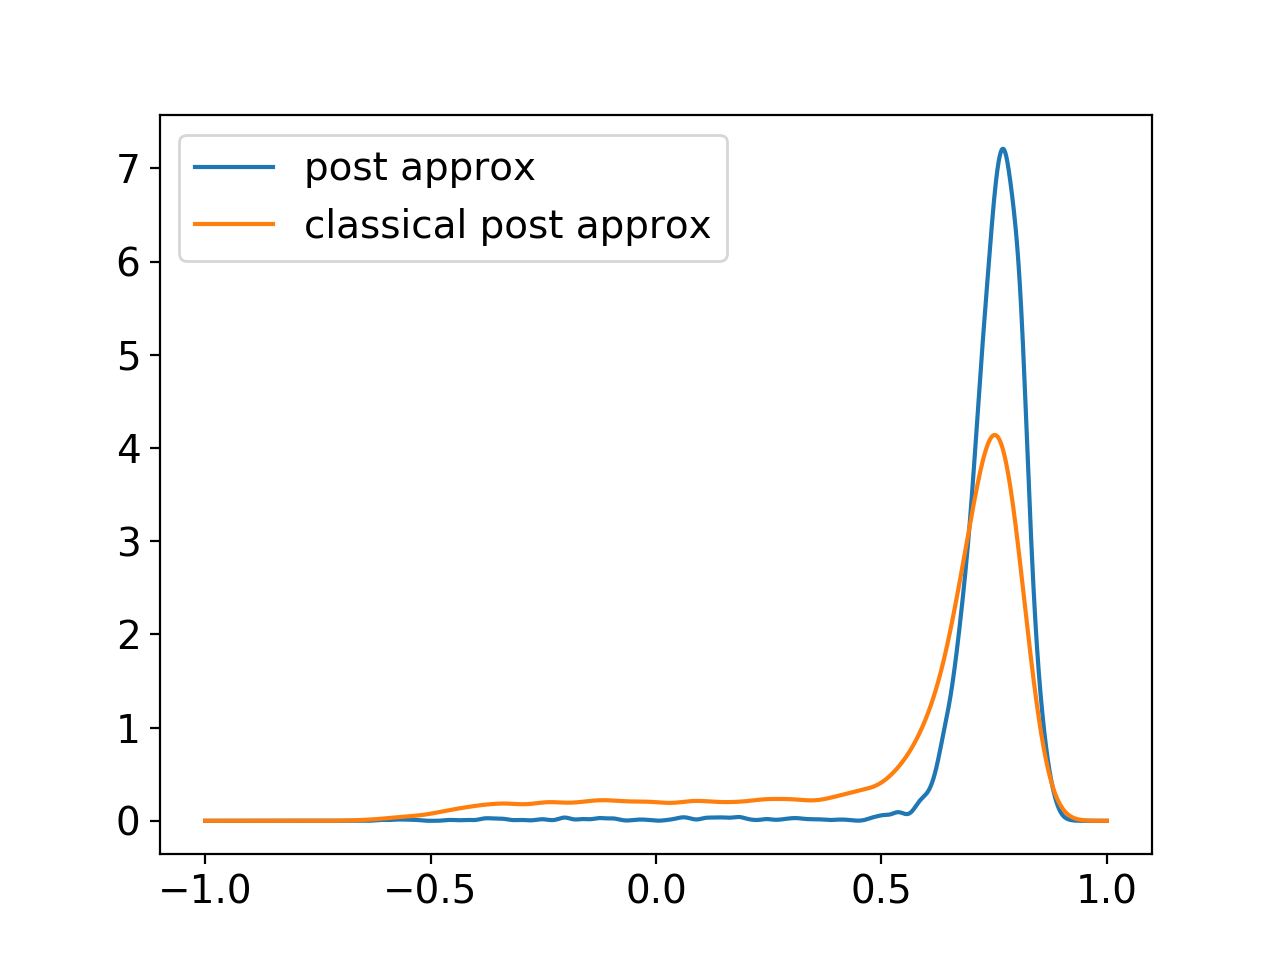

In [23]:
x = np.linspace(-1.0,1.0,2000)

plt.figure()

#plt.plot(x,pf_dens.evaluate(x),'r',label='push-forward')
#plt.plot(x,obs_dens.pdf(x),'b',label='observed')
#plt.plot(x,pf_classical(x),label='stat Bayes')
#plt.plot(x,obs_dens.pdf(x),'--',label='observed')
plt.plot(x,post_approx.pdf(x),label='post approx')
plt.plot(x,post_approx_classical.pdf(x),label='classical post approx')
plt.legend()
#plt.legend()
plt.show()